### Volume analysis through Nup133 labeling
Script that aims to analyze cell microscopy data in order to gain insight into cell volume dynamics.
Made by Olle de Jong, based on preexisting microscopy analysis files by Luc-Alban Vuillemenot.

In [2]:
""" Imports """
import os
import random
import re
import copy
from math import pi, sin, cos
import pandas as pd
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.ndimage import center_of_mass, binary_erosion
import seaborn as sns
from skimage import measure
from skimage.io import imread, imshow
from skimage.filters import threshold_local, threshold_otsu, try_all_threshold, threshold_minimum, threshold_yen, rank
from skimage.morphology import remove_small_objects, disk
import bottleneck as bn
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [3]:
""" Globals """
# globally define bottleneck 'nanmean' estimator
nan_mean = bn.nanmean

# IMPORTANT PATHS
# Data files
data_dir = "C:/Users/Olle de Jong/Documents/MSc Biology/MSB Research/Code and data/Data"
tiff_files_dir = data_dir + "/processed_tiffs_nup133/"  # relative path from data directory to tiff directory
img_output_dir = data_dir + "/Output/"  # relative path from data directory to image output directory
# Data sheets
budj_data_folder = data_dir + "/Other/Nup133/BudJ/"  # folder that holds the BudJ info on all cells
budding_data_path = data_dir + "/Other/Nup133/buddings.txt"  # budding events
kario_data_path = data_dir + "/Other/Nup133/kariokinesis.txt"  # kariokinesis events

# thresholding globals
scaling_factor = 0.16  # microns per pixel ---> 100x objective
bloc_size_frac_to_use = 0.09
offset_to_use = -50

Now we define a couple of functions that will be used throughout the analysis process. There's a function for time conversion from 'frame' time to real time, since one frame is equal to 5 real time minutes. For function descriptions, see the function's docstring.

In [4]:
def ellipse_from_budj(t, cell_data, scaling_factor):
    """
    Define the function that can extract parameters of the ellipse using the data
    Function to extract parameters of the ellipse from the BudJ table
    """
    data_at_frame = cell_data[cell_data["TimeID"] == t]
    x_pos = float(data_at_frame['x']) / scaling_factor
    y_pos = float(data_at_frame['y']) / scaling_factor
    majorR = float(data_at_frame["Major R"]) / scaling_factor
    minorR = float(data_at_frame["Minor r"]) / scaling_factor
    angle = float(data_at_frame['Angle']) * (pi / 180)  # convert to radians
    return x_pos, y_pos, majorR, minorR, angle

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def plot_from_list(fig_title, data_list, xlim, ylim, save_fig=False, filename="test.png"):
    """
    Given a dictionary that holds image data, plot those in one figure
    """
    if save_fig:
        plt.ioff()
    fig = plt.figure(
        figsize=(4 * len(data_list), 4.2),
        edgecolor="black",
        frameon=True,
        facecolor="white",
        layout="tight"
    ).suptitle(fig_title, fontsize=14, y=1)
    i = 1
    for data in data_list:
        subplt = plt.subplot(1, len(data_list), i)
        subplt.set_title(label=data[0], y=1.02)
        plt.imshow(data[1], cmap="hot")
        subplt.grid(False)
        plt.xlim(xlim)
        plt.ylim(ylim)
        i += 1
    if save_fig:
        plt.savefig(img_output_dir + filename)
    else:
        plt.show()

In [5]:
"""Conversion from TimeIDs to time points in minutes """
TimeIDs = 150
time_step = 5

TimeIDs = range(1, TimeIDs + 1, 1) #+1 because the last number is not accounted
time_mins = []

for i in TimeIDs:
    t = time_step*(i-1)
    time_mins.append(t)

time_conversion = pd.DataFrame({"TimeID" : TimeIDs, "Time" : time_mins})

Now that we've loaded some handy functions, we can proceed with creating a function for loading BudJ data. One file contains the information for one position which include one through three/four individual cells.

In [6]:
"""
Load all the BudJ data from the files and concatenate that data in one dataframe
"""
files = []
for filename in os.listdir(budj_data_folder):
    if ".csv" in filename:
        prefix_position = f"pos{filename[-25:-23]}_"
        files.append((filename, prefix_position))

budj_data = pd.DataFrame({})
for f in files:
    pos_data = pd.read_csv(budj_data_folder+ f[0], header=0, index_col=0)
    pos_data["Cell_pos"] = f[1] + pos_data["Cell"].map(str)
    pos_data = pos_data.loc[:, ["TimeID", "Cell_pos", "Volume", "x", "y", "Major R", "Minor r", "Angle"]]
    budj_data = pd.concat([budj_data, pos_data])

budj_data = pd.merge(budj_data, time_conversion, on="TimeID")
budj_data = budj_data.sort_values(["Cell_pos", "TimeID"])
print(budj_data)

individual_cells = sorted(list(set(budj_data["Cell_pos"])))
print(f"There are {len(individual_cells)} cells in the data.")

      TimeID Cell_pos  Volume      x      y  Major R  Minor r  Angle  Time
0         15  pos01_1   39.03  38.57  48.82     2.26     1.95  73.46    70
37        16  pos01_1   39.92  38.67  49.05     2.31     1.93  76.06    75
82        17  pos01_1   39.13  38.58  49.32     2.28     1.93  80.79    80
127       18  pos01_1   39.17  38.48  49.23     2.28     1.94  81.57    85
172       19  pos01_1   40.79  38.55  49.29     2.31     1.96  80.58    90
...      ...      ...     ...    ...    ...      ...      ...    ...   ...
1664      49  pos20_4   59.94  67.59  32.52     2.57     2.28  16.14   240
1713      50  pos20_4   57.13  67.57  32.34     2.59     2.19  17.64   245
1762      51  pos20_4   62.87  67.46  32.29     2.62     2.32  41.24   250
1809      52  pos20_4   66.76  67.46  32.22     2.72     2.32  46.18   255
1855      53  pos20_4   70.29  67.67  32.31     2.71     2.41 -86.91   260

[3489 rows x 9 columns]
There are 50 cells in the data.


Now, lets load the budding and karyoginesis event timepoints from the by BudJ produced files.

In [7]:
"""
Load the data from the kario/budding event files
"""
events_files = {"budding": budding_data_path, "kariokinesis": kario_data_path}

budding_events = {}
kario_events = {}
for event_type in events_files:  # for either budding or kariokinesis events
    opened_file = open(events_files[event_type])  # open the file
    events = {}  # temp storage object
    for line in opened_file:  # every line in the file is a cell
        if line == "\n":
            continue
        # process the two parts of the line by removing characters
        parts = line.split(':')
        cell_id = parts[0].replace("\"", "")  # first part of the line is the individual cell
        timepoints = re.sub('[\,\[\]]', "", parts[1])  # second part are the timepoints
        # split timepoints on space to capture them in a list
        events[cell_id] = timepoints.split(" ")

    # save the events to the right dictionary
    if event_type == "budding":
        budding_events = events
    if event_type == "kariokinesis":
        kario_events = events
    opened_file.close()

print(f"There are budding events for {len(budding_events)} cells")
print(f"There are karyokinesis events for {len(kario_events)} cells")

There are budding events for 50 cells
There are karyokinesis events for 50 cells


Lets also define a function, since it will be used multiple times, for getting the whole cell mask based on the BudJ data.

In [8]:
def get_whole_cell_mask(t, single_cell_data, image_shape):
    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

    y_dim, x_dim = image_shape  # get the dimensions (512x512)

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    return (
            (
                (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                 +
                (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
            ) # if this sum
            < 0  # is smaller than zero
    ), x_pos, y_pos

### Whole cell masking using BudJ data

Lets take a look at cell pos02_1.


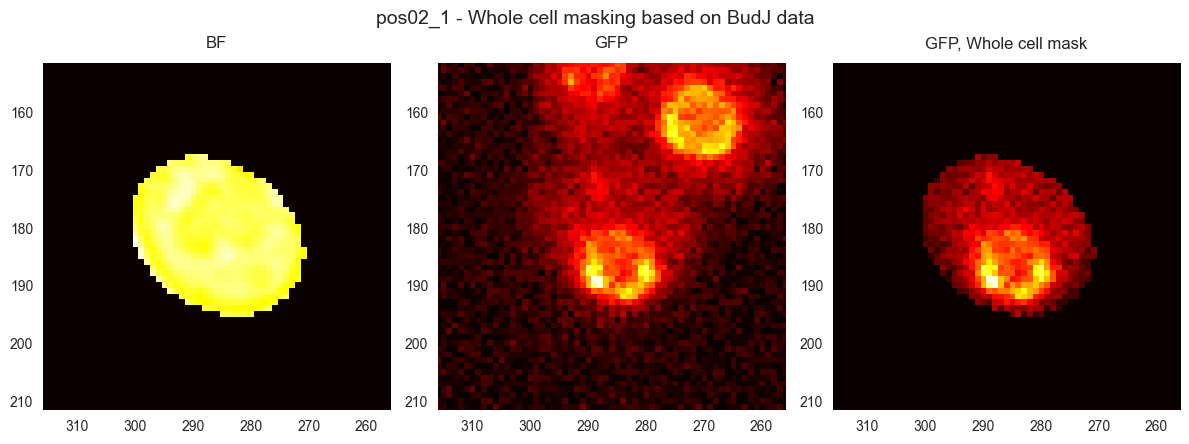

In [38]:
"""
The image channels are split, where after the whole cell mask is created. That, and the
two original channels are plotted, which makes them visually comparable.
"""
pos = "02"
cell_pos = "pos02_1"

# This image variable is a 4 dimensional array. The outer array of 150 length holds matrices of
# 512 by 512 pixels. These each hold 2 values. Index 0: BF channel, index 1: GFP channel
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

# let's take cell 2 of position 01 as example
cell = 1

print(f"Lets take a look at cell {cell_pos}.")

# get the data for the single cell
single_cell_data = budj_data[budj_data["Cell_pos"] == cell_pos]

t = 16
t_in_tiff = t - 1  # skew the time by one

imageBF = image[t_in_tiff, 0, :, :]
imageGFP = image[t_in_tiff, 1, :, :]

# get the whole cell mask
whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

# plot the regular BF and GFP channels and compare this to the masked whole cell (based on ImageJ data)
to_plot = [
    ["BF", imageBF * whole_cell_mask, "hot"],
    ["GFP", imageGFP, "hot"],
    ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"]
]
plot_from_list(f"{cell_pos} - Whole cell masking based on BudJ data", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

### Comparing multiple thresholding methods
Here we compare multiple thresholding methodologies. This is done on multiple randomly chosen cells. Local thresholding generates a threshold mask image based on local pixel neighborhood. The algorithm behind Otsu thresholding searches for the threshold that minimizes the intra-class variance to essentially split the pixels into two classes.

Randomly picked cells ['pos02_3', 'pos20_4', 'pos07_4', 'pos10_3', 'pos07_3'] to perform thresholding on.


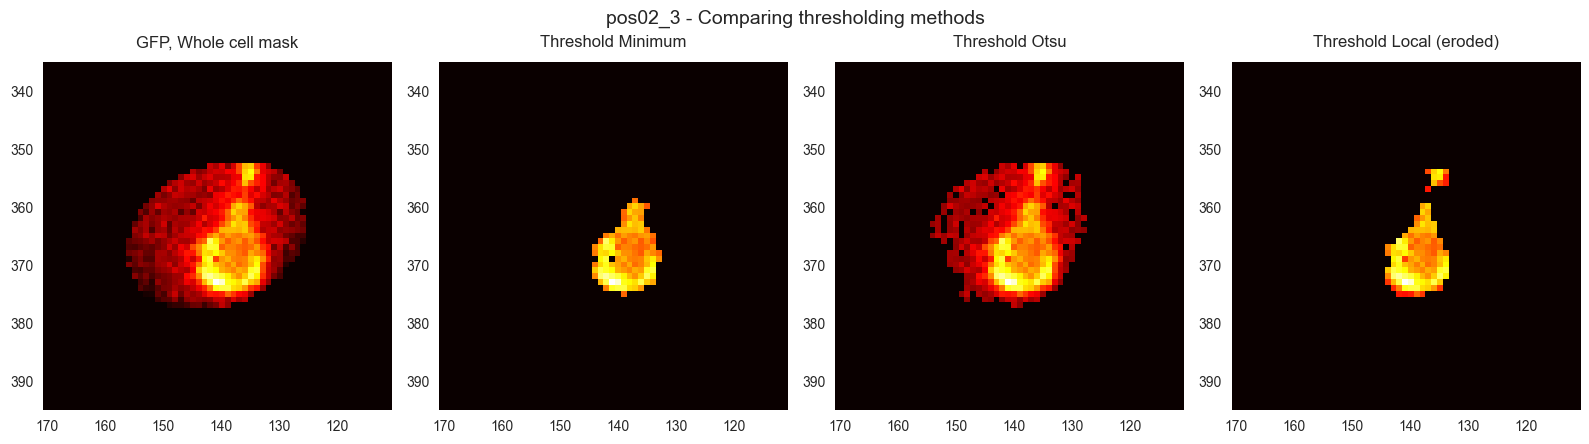

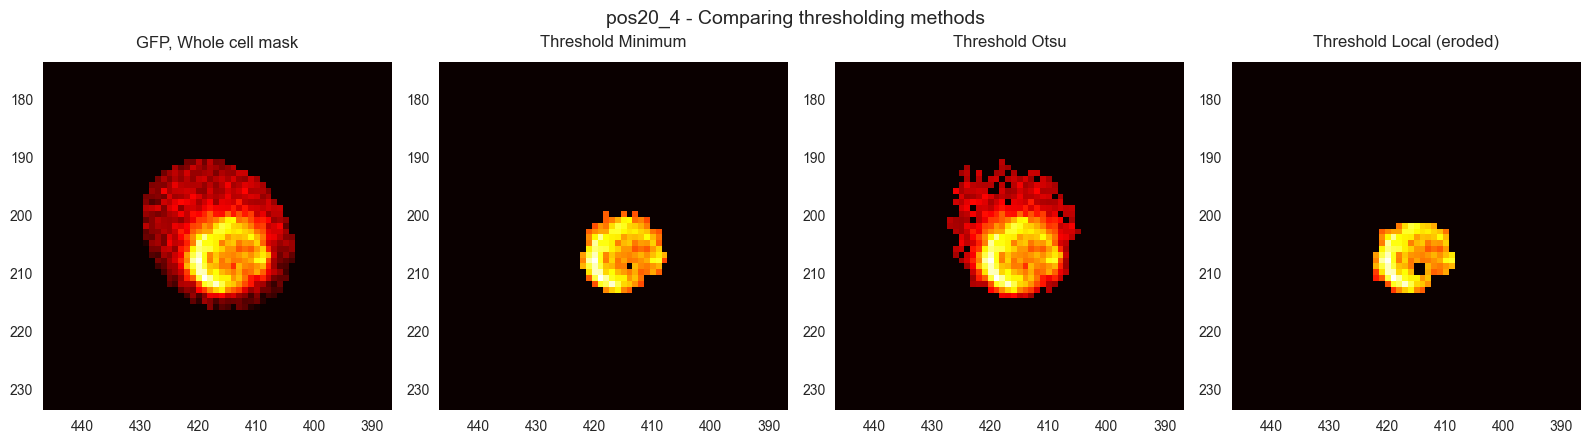

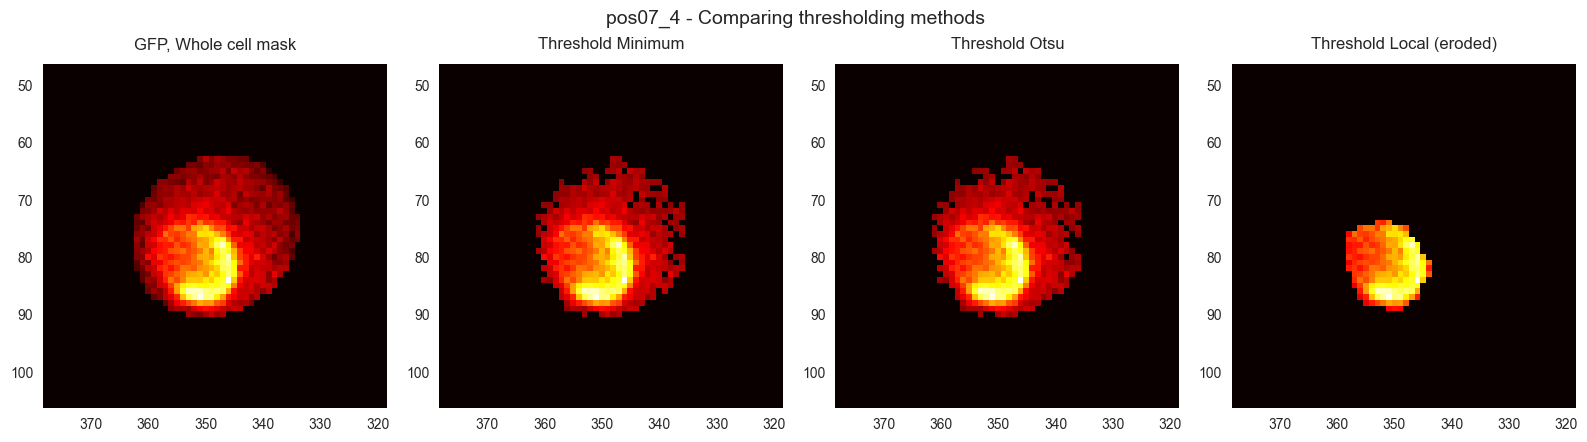

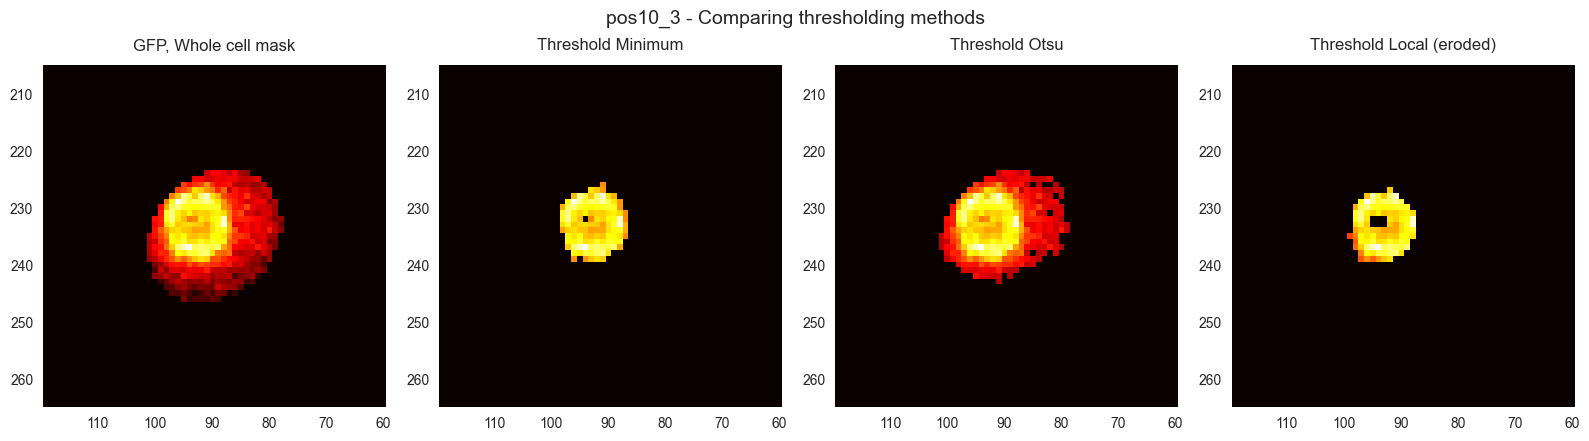

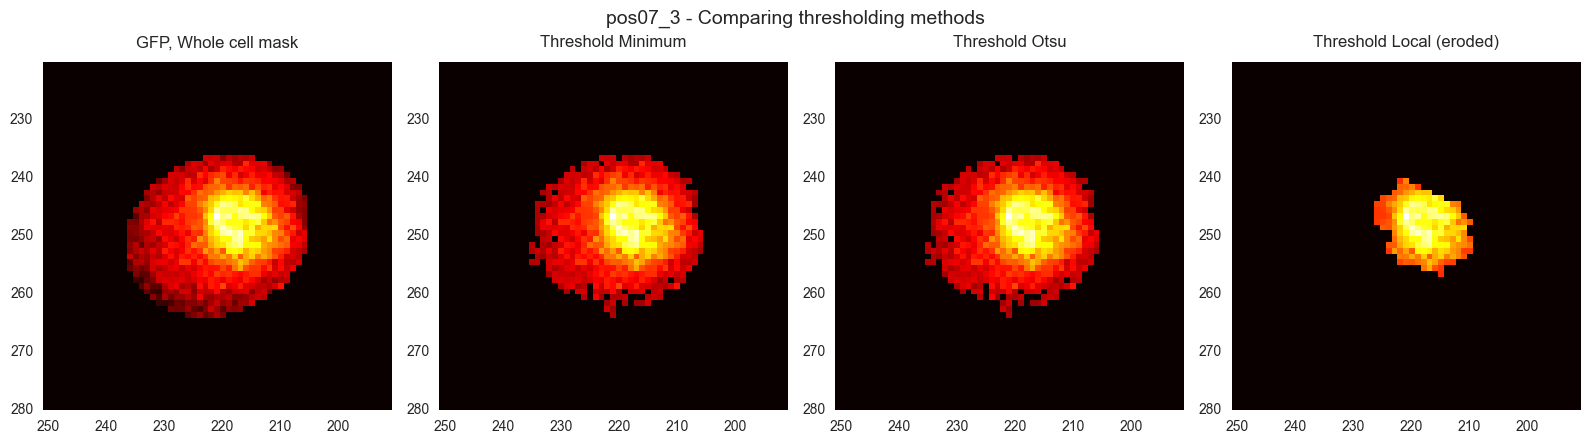

In [46]:
random_cells = random.sample(individual_cells, 5)
print(f"Randomly picked cells {random_cells} to perform thresholding on.")

for cell in random_cells:
    pos = cell[3:5]

    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    # get the first available frame
    t = single_cell_data['TimeID'].iloc[0]
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    # adaptive thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask

    # thresholding for getting the nuclear mask
    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    nucl_thresh_mask_otsu = threshold_otsu(imageGFP_cell_mask)  # perform otsu thresholding
    nucl_thresh_mask_minimum = threshold_minimum(imageGFP_cell_mask)  # perform minimum thresholding

    # keep the nucleus pixels that are greater than the local threshold (either with or without erosion)
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_minimum = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_minimum)
    imageGFP_nuc_mask_otsu = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_otsu)

    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask],
        ["Threshold Minimum", imageGFP * imageGFP_nuc_mask_minimum],
        ["Threshold Otsu", imageGFP * imageGFP_nuc_mask_otsu],
        ["Threshold Local (eroded)", imageGFP * imageGFP_nuc_mask_local_eroded]
    ]

    plot_from_list(f"{cell} - Comparing thresholding methods", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

Notes: local thresholding, after erosion, seems to give the most accurate fit to the nucleus. Minimum thresholding is also performing well, but as you can tell, when the nuclear intensity is not sufficiently high, the minimum method does not result in the desired result at all. In this case, it seems unreliable because of its all-or-nothing nature. Once the piece of investigative code above is run a couple of times, we find that thresholding with erosion performs best.

### Fitting the nuclear ellipse
Using the best thresholding method chosen from options above (Local (eroded) for now)

In [41]:
"""
Function that generates and fits the ellipse using the opencv package. It takes a nuclear mask as argument.
"""
def get_ellipse(cell_name, imageRFP, nuc_mask):
    mask = imageRFP * nuc_mask
    thresh = mask.astype(np.uint8)  # change type to uint8

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # if there is a contour found
    if len(contours) > 0:
        return cv2.fitEllipse(max(contours, key=len))

Using the above created get_ellipse function, we now plot the original RFP channel, the two versions of nuclear thresholding (non-eroded and eroded) and the fitted ellipse all in one figure to provide an overview of the performance.

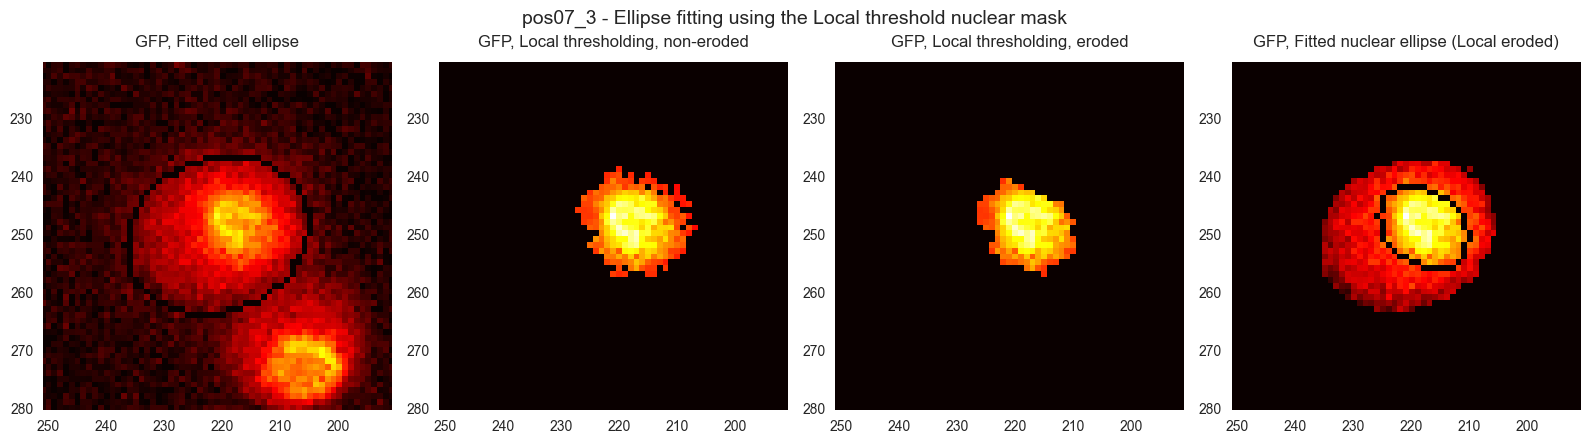

The major and minor axes of the ellipse are 17.07475471496582 and 12.641857147216797, respectively.


In [47]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local_eroded)  # use imageRFP and nuc_mask_otsu from last plotted cell above
cv2_ellipse = ((x, y), (MA, ma), angle)

(c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(cell, imageGFP, whole_cell_mask)
cv2_ellipse_cell = ((c_x, c_y), (c_MA, c_ma), c_angle)

# plot side by side
to_plot = [
    ["GFP, Fitted cell ellipse", cv2.ellipse(imageGFP, cv2_ellipse_cell, (0, 0, 0), 1)], # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
    ["GFP, Local thresholding, non-eroded", imageGFP * imageGFP_nuc_mask_local],
    ["GFP, Local thresholding, eroded", imageGFP * imageGFP_nuc_mask_local_eroded],
    ["GFP, Fitted nuclear ellipse (Local eroded)", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1)] # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
]
plot_from_list(f"{cell} - Ellipse fitting using the Local threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

print(f"The major and minor axes of the ellipse are {ma} and {MA}, respectively.")

### Ellipse fitting performance over time
To get an insight in how well our nuclear thresholding approach performs, the following code block generates the fitted nuclear ellipse for all timepoints for a particular cell. The figure is saved to the Data/Output folder.

In [48]:
ellipses = []
cell = "pos15_1"
pos = cell[3:5]
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # pick only the data of the first cell

print(f"Generating ellipse fit overview for cell {cell} ..")
first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

timerange = [i for i in range(first_t, last_t)]
for t in timerange:
    # skew the time by one for tiff dataframe
    t_in_tiff = t - 1

    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

    imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
    y_dim, x_dim = imageGFP.shape  # get the dimensions

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    whole_cell_mask = (
        (
            (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
             +
            (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
        ) # if this sum
        < 0  # is smaller than zero
    )

    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

    try:
        (x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local_eroded)
        cv2_ellipse = ((x, y), (MA, ma), angle)
    except TypeError:
        print(f"Failed to get ellipse for {cell} at t={t}")
        continue

    # also fit an ellipse on the whole cell mask
    (c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(cell, imageGFP, whole_cell_mask)

    # print(f"Cell area: {(np.sum(whole_cell_mask)) * scaling_factor**2}, nuclear area: {pi * (MA * scaling_factor) * (ma * scaling_factor) / 4}")
    # TODO Since the cell volume is heavily underestimated, I chose to ignore the majorR and minorR from the BudJ data, and got them from fitting an ellipse as well.
    r1c = (c_MA * scaling_factor) # to get the semi-major axis
    r2c = (c_ma * scaling_factor) # to get the semi-minor axis
    r3c = (np.min((c_MA, c_ma)) * scaling_factor) # to get the third axis (average of two known axes)
    cell_volume = (4/3) * pi * r1c * r2c * r3c

    r1n = (MA * scaling_factor) # to get the semi-major axis
    r2n = (ma * scaling_factor) # to get the semi-minor axis
    r3n = (np.min((MA, ma)) * scaling_factor) # to get the third axis (average of two known axes)
    nuc_volume = (4/3) * pi * r1n * r2n * r3n
    # save the fitted ellipse for this timepoitn to a list
    ellipses.append((t, x_pos, y_pos, cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1), cell_volume, nuc_volume))

plt.ioff()
fig = plt.figure(
    figsize=(35, 25),
    edgecolor="black",
    frameon=True,
    facecolor="white",
    layout="tight"
).suptitle(f"Cell {cell} - Fitted ellipses over time", fontsize=14, y=0.99)
for ellipse in ellipses:
    subplt = plt.subplot(10, 15, ellipse[0])
    subplt.set_title(label=f"t = {ellipse[0]}, N/Cell = {round(ellipse[5] / ellipse[4], 4)}", y=1.02)
    plt.imshow(ellipse[3], cmap="hot")
    subplt.grid(False)
    plt.xlim(ellipse[1] + 30, ellipse[1] - 30)
    plt.ylim(ellipse[2] + 30, ellipse[2] - 30)
plt.savefig(img_output_dir + f"{cell}_ellipse_over_time.png", dpi=500)

Generating ellipse fit overview for cell pos15_1 ..
Failed to get ellipse for pos15_1 at t=93


### Comparing the volume dynamics of multiple cells over time
#### Generate volume data both whole cell and nuclei

In [15]:
# variables to store x and y data in that will be plotted per cell
time_vol_dat = []
time_vol_dat_nuc = []

for pos in range(1,20):
    if pos < 10:
        pos = "0"+ str(pos)
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image

    for cell in individual_cells:
        if 'pos'+str(pos) in cell and cell == "pos03_2":
            could_not_fit = 0
            print(f"Working with cell {cell} ..")

            single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell
            first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
            last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

            cell_volumes = []
            nuc_volumes = []
            timerange = [i for i in range(first_t, last_t)]
            for t in timerange:
                # skew the time by one for tiff dataframe
                t_in_tiff = t - 1

                # get/calculate the ellipse information
                x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

                imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
                y_dim, x_dim = imageGFP.shape  # get the dimensions

                # create an ogrid that helps us select/'mask' the info we want
                row, col = np.ogrid[:y_dim, :x_dim]

                # get the mask of the whole cell
                whole_cell_mask = (
                    (
                        (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                         +
                        (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
                    ) # if this sum
                    < 0  # is smaller than zero
                )

                imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

                num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
                bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

                nucl_thresh_mask_local = threshold_local(  # local thresholding
                    image=imageGFP_cell_mask,
                    block_size=bloc_size_cell_size_dependent,
                    method='gaussian',
                    offset=offset_to_use,
                    mode='reflect'
                )
                imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
                imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

                try:
                    (x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local_eroded)
                except TypeError:
                    could_not_fit += 1
                    continue
                cv2_ellipse = ((x, y), (MA, ma), angle)

                # Ellipse Volume Formula = 4/3 * π * A * B * C, where we assume that the third axis is equal to the average of the two axes
                cell_volume = 4/3 * pi * majorR * minorR * ((minorR + majorR) / 2)
                nuc_volume = 4/3 * pi * MA * ma * ((ma + MA) / 2) # MA is actually ma
                print(cell_volume, nuc_volume)

                # append volumes for this datapoint to list holding volumes for all timepoints
                cell_volumes.append(cell_volume)
                nuc_volumes.append(nuc_volume)
            # append the data series for this cell to the list holding it for all cells
            time_vol_dat.append((cell, cell_volumes))
            time_vol_dat_nuc.append((cell, nuc_volumes))
            print(f"Couldn't fit ellipse {could_not_fit} out of {len(timerange)} times")

Working with cell pos03_2 ..
13724.366575210892 14388.999109554252
14180.88437095495 10828.82680394761
14074.335088082275 10733.090357917767
14266.312783686157 11457.183671893412
14279.128681842012 12462.766904885486
14010.723972770229 13818.923273224811
13648.900856370066 13182.562193986689
13136.919428605359 14721.835300602634
13217.801122281275 13009.289748897025
13224.77050832757 13068.883996931869
13306.132849317024 14127.090749537965
12975.830992800195 11924.003512768883
13056.26271877833 8061.723833455671
19130.918677652742 6671.5945173509335
13231.259247060325 8742.945150197776
13667.845519100456 9143.590595767366
14835.659979648499 10068.276851836421
14924.820056309707 10532.017748821972
14929.320755941359 10114.584748858424
15203.805142202467 10198.751000794979
14198.5926451703 11208.355081909307
14371.237069577532 14950.992826755954
14351.97333884327 13835.998090286927
14643.896018701056 15340.492623486363
14929.320755941359 14590.209358451
15394.432934713017 19317.870399922

In [99]:
# print some metrics on the data
print(f"The lengths of the cell volume and nuclear volume data are {len(time_vol_dat)} and {len(time_vol_dat_nuc)}, respectively.")

The lengths of the cell volume and nuclear volume data are 46 and 46, respectively.


#### Plot the generated whole-cell volume data

In [101]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Total cell volumes over time", fontsize=16, y=1)

# plot in a grid
count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("cells_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Plot the generated nuclear volume data

In [102]:
# create figure 3 by 5
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat_nuc[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].set_title(f"{time_vol_dat_nuc[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("nuc_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Combine the volumes
Now plot the nuclear and whole cell volumes in one figure and save this instead of plotting it here.

In [103]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat[count][1]
            volume_data_nuc = time_vol_dat_nuc[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].plot(volume_data_nuc)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("volumes_overT_together.png", bbox_inches='tight', dpi=350)
plt.close(fig)

### Investigation of outliers in nuclear volume
We can see from the volumes_over_T_together image file that there are quite a few cells where the nuclear volume exceeds that of the entire cell. This cannot be possible, and thus requires investigation of how to erase these timepoints.
#### Removal of the datapoints where the nuclear volume exceeds the total cell volume

In [201]:
# make sure we copy the original volume data, and not overwrite it
time_vol_dat_filtered = copy.deepcopy(time_vol_dat)
time_vol_dat_nuc_filtered = copy.deepcopy(time_vol_dat_nuc)

for i in range(0, len(time_vol_dat_filtered)):
    # grab all the individual components of the data
    cell_name = time_vol_dat_filtered[i][0]
    time = time_vol_dat_filtered[i][1]
    volume_data = time_vol_dat_filtered[i][2]
    time_nuc = time_vol_dat_nuc_filtered[i][1]
    volume_data_nuc = time_vol_dat_nuc_filtered[i][2]

    # get the indexes that have to be removed
    indexes = []
    j = 0
    filter_count = 0
    for nuc_vol in volume_data_nuc:
        if nuc_vol > volume_data[j]:
            indexes.append(j)
            filter_count += 1
        j += 1

    # remove the indexes in backwards manner from all the data instances
    for index in sorted(indexes, reverse=True):
        del time[index]
        del volume_data[index]
        del time_nuc[index]
        del volume_data_nuc[index]
    print(f"Removed {filter_count} datapoints for {cell_name}")
    i += 1

Removed 20 datapoints for pos01_1
Removed 10 datapoints for pos01_2
Removed 17 datapoints for pos01_3
Removed 5 datapoints for pos02_1
Removed 1 datapoints for pos03_1
Removed 1 datapoints for pos03_2
Removed 2 datapoints for pos04_1
Removed 8 datapoints for pos04_2
Removed 5 datapoints for pos04_3
Removed 0 datapoints for pos06_1
Removed 1 datapoints for pos06_2
Removed 0 datapoints for pos07_1
Removed 4 datapoints for pos07_2
Removed 2 datapoints for pos08_2
Removed 13 datapoints for pos09_1
Removed 0 datapoints for pos09_2
Removed 7 datapoints for pos09_3
Removed 5 datapoints for pos09_4
Removed 5 datapoints for pos10_1
Removed 3 datapoints for pos10_2
Removed 15 datapoints for pos11_1
Removed 8 datapoints for pos11_2
Removed 2 datapoints for pos12_1
Removed 32 datapoints for pos12_2
Removed 8 datapoints for pos13_1
Removed 0 datapoints for pos13_2
Removed 3 datapoints for pos13_3
Removed 0 datapoints for pos13_4
Removed 2 datapoints for pos14_1
Removed 10 datapoints for pos14_2
Rem

Let's plot the filtered data and save the figure.

In [195]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            cell_name = time_vol_dat_filtered[count][0]
            time = time_vol_dat_filtered[count][1]
            vol_data = time_vol_dat_filtered[count][2]
            time_nuc = time_vol_dat_nuc_filtered[count][1]
            vol_data_nuc = time_vol_dat_nuc_filtered[count][2]

            ax[i,j].plot(time, vol_data)
            ax[i,j].plot(time_nuc, vol_data_nuc)
            ax[i,j].set_title(f"{cell_name}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("volumes_overT_together_removed_outliers.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Removal of the datapoints where N/C ratio is too high

In [205]:
# make sure we copy the original volume data, and not overwrite it
time_vol_dat_filtered_ratio = copy.deepcopy(time_vol_dat)
time_vol_dat_nuc_filtered_ratio = copy.deepcopy(time_vol_dat_nuc)

for i in range(0, len(time_vol_dat_filtered_ratio)):
    # grab all the individual components of the data
    cell_name = time_vol_dat_filtered_ratio[i][0]
    time = time_vol_dat_filtered_ratio[i][1]
    volume_data = time_vol_dat_filtered_ratio[i][2]
    time_nuc = time_vol_dat_nuc_filtered_ratio[i][1]
    volume_data_nuc = time_vol_dat_nuc_filtered_ratio[i][2]

    # get the indexes that have to be removed
    indexes = []
    j = 0
    filter_count = 0
    for nuc_vol in volume_data_nuc:
        if (nuc_vol / volume_data[j]) > 0.65: # TODO play with this value
            indexes.append(j)
            filter_count += 1
        j += 1

    # remove the indexes in backwards manner from all the data instances
    for index in sorted(indexes, reverse=True):
        del time[index]
        del volume_data[index]
        del time_nuc[index]
        del volume_data_nuc[index]
    print(f"Removed {filter_count} datapoints for {cell_name}")
    i += 1

Removed 35 datapoints for pos01_1
Removed 24 datapoints for pos01_2
Removed 21 datapoints for pos01_3
Removed 20 datapoints for pos02_1
Removed 11 datapoints for pos03_1
Removed 17 datapoints for pos03_2
Removed 16 datapoints for pos04_1
Removed 24 datapoints for pos04_2
Removed 34 datapoints for pos04_3
Removed 3 datapoints for pos06_1
Removed 12 datapoints for pos06_2
Removed 0 datapoints for pos07_1
Removed 5 datapoints for pos07_2
Removed 21 datapoints for pos08_2
Removed 23 datapoints for pos09_1
Removed 2 datapoints for pos09_2
Removed 30 datapoints for pos09_3
Removed 17 datapoints for pos09_4
Removed 14 datapoints for pos10_1
Removed 12 datapoints for pos10_2
Removed 30 datapoints for pos11_1
Removed 33 datapoints for pos11_2
Removed 6 datapoints for pos12_1
Removed 51 datapoints for pos12_2
Removed 14 datapoints for pos13_1
Removed 8 datapoints for pos13_2
Removed 7 datapoints for pos13_3
Removed 15 datapoints for pos13_4
Removed 8 datapoints for pos14_1
Removed 34 datapoints 

Let's plot the filtered data once more

In [ ]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            cell_name = time_vol_dat_filtered_ratio[count][0]
            time = time_vol_dat_filtered_ratio[count][1]
            vol_data = time_vol_dat_filtered_ratio[count][2]
            time_nuc = time_vol_dat_nuc_filtered_ratio[count][1]
            vol_data_nuc = time_vol_dat_nuc_filtered_ratio[count][2]
            ax[i,j].plot(time, vol_data)
            ax[i,j].plot(time_nuc, vol_data_nuc)
            ax[i,j].set_title(f"{cell_name}", fontstyle='italic', y=1.02)
            count += 1
# plt.savefig("volumes_overT_together_removed_outliers_ratio.png", bbox_inches='tight', dpi=350)
plt.close(fig)

### Some more outlier removal testing

#### Investigation of Otsu mask pixel intensity

Lets figure out a way to delete the volume datapoints at points where we cannot be certain that the nuclear mask created by Otsu thresholding is accurate. This could be done by removing all datapoints where the Otsu threshold value is below a certain value. See the small demonstration below.

In [207]:
# test_cells = ["pos04_1", "pos02_1", "pos07_2"]
individual_cells = sorted(list(set(cell_data["Cell_pos"])))

outlier_thresh = 12  # manually determined threshold for outlier removal

for cell in individual_cells:
    if cell == "pos08_1":  # somehow this cell acts up
        continue
    pos = cell[3:5]  # substring position for image loading TODO can be more efficient (through loading image only once per position)
    image = imread(os.path.join(tiff_files_dir + "20191028_sfp1_tod6_agar_rep5_xy" + pos + ".nd2.tif"))

    single_cell_data = cell_data[cell_data["Cell_pos"] == cell]
    first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
    last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

    timerange = range(first_t, last_t)
    lower_than = 0
    for t in timerange:
        # skew the time by one for tiff dataframe
        t_in_tiff = t - 1

        imageRFP = image[t_in_tiff, :, :, 2]  # get the data from the RFP channel

        whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, imageRFP.shape)  # get the cell mask based on BudJ data

        imageRFP_cell_mask = imageRFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask
        nucl_thresh_mask_otsu = threshold_otsu(imageRFP_cell_mask)  # perform otsu thresholding

        if nucl_thresh_mask_otsu < outlier_thresh:
            lower_than += 1  # count for how many frames the threshold value is below 15

        imageRFP_nuc_mask_otsu = imageRFP_cell_mask > nucl_thresh_mask_otsu  # keep only otsu threshold

        # (x, y), (MA, ma), angle = get_ellipse(cell, imageRFP, imageRFP_nuc_mask_otsu)
        # cv2_ellipse = ((x, y), (MA, ma), angle)
        # if 4/3 * pi * MA * ma * ((ma + MA) / 2) > 20000:
        #     print("over")

    print(f"In {cell} there are {lower_than} Otsu thresholds lower than {outlier_thresh}")

In pos01_1 there are 24 Otsu thresholds lower than 12
In pos01_2 there are 1 Otsu thresholds lower than 12
In pos01_3 there are 12 Otsu thresholds lower than 12
In pos02_1 there are 3 Otsu thresholds lower than 12
In pos03_1 there are 0 Otsu thresholds lower than 12
In pos03_2 there are 1 Otsu thresholds lower than 12
In pos04_1 there are 4 Otsu thresholds lower than 12
In pos04_2 there are 11 Otsu thresholds lower than 12
In pos04_3 there are 1 Otsu thresholds lower than 12
In pos06_1 there are 0 Otsu thresholds lower than 12
In pos06_2 there are 0 Otsu thresholds lower than 12
In pos07_1 there are 0 Otsu thresholds lower than 12
In pos07_2 there are 5 Otsu thresholds lower than 12
In pos08_2 there are 1 Otsu thresholds lower than 12
In pos09_1 there are 3 Otsu thresholds lower than 12
In pos09_2 there are 0 Otsu thresholds lower than 12
In pos09_3 there are 0 Otsu thresholds lower than 12
In pos09_4 there are 0 Otsu thresholds lower than 12
In pos10_1 there are 1 Otsu thresholds lowe

#### z_score and percentile/quartile approaches

In [164]:
# TODO find outliers based on z_score (how many standard deviations from the mean)
test_nuc = copy.deepcopy(time_vol_dat_nuc)

outliers = []
def detect_outliers(data):
    threshold = 2.5
    mean = np.mean(data)
    std = np.std(data)

    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)

    return outliers


print(test_nuc[3][0])
print(detect_outliers(test_nuc[3][2]))

pos02_1
[15932.556905501355, 30325.949212013897, 22585.821274992308, 16774.321619370723]


In [161]:
# outlier detection using percentile/quartile
quan1, quan3 = np.percentile(test_nuc[2][2], [25, 75])
iqr = quan3 - quan1
upper_bound_val = quan3 + (2.5 * iqr)

print(upper_bound_val)

# TODO this might work fine, but only as an additional filtering option

19692.424969647353
